In [16]:
import os
import pandas as pd
from ipywidgets.widgets import Dropdown, interact
from ipywidgets import Button, HBox, VBox, interactive_output

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,8)

In [2]:
os.listdir('data')

['holidays_events.parquet.gzip',
 'oil.parquet.gzip',
 'sample_submission.parquet.gzip',
 'stores.parquet.gzip',
 'test.parquet.gzip',
 'train.parquet.gzip',
 'transactions.parquet.gzip']

In [3]:
all_data = {}
for file in os.listdir('data'):
    filename = file.split('.')[0]
    all_data[filename] = pd.read_parquet('data/{}'.format(file),)
    
all_data.keys()

dict_keys(['holidays_events', 'oil', 'sample_submission', 'stores', 'test', 'train', 'transactions'])

In [4]:
train, stores, holidays_events, oil = (all_data['train'], all_data['stores'], 
         all_data['holidays_events'], all_data['oil'])
for data in (train, holidays_events, oil):
    data['date'] = data['date'].astype('datetime64[ns]')

In [5]:
train = train.merge(holidays_events,on='date', how='left').merge(oil,on='date', how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN


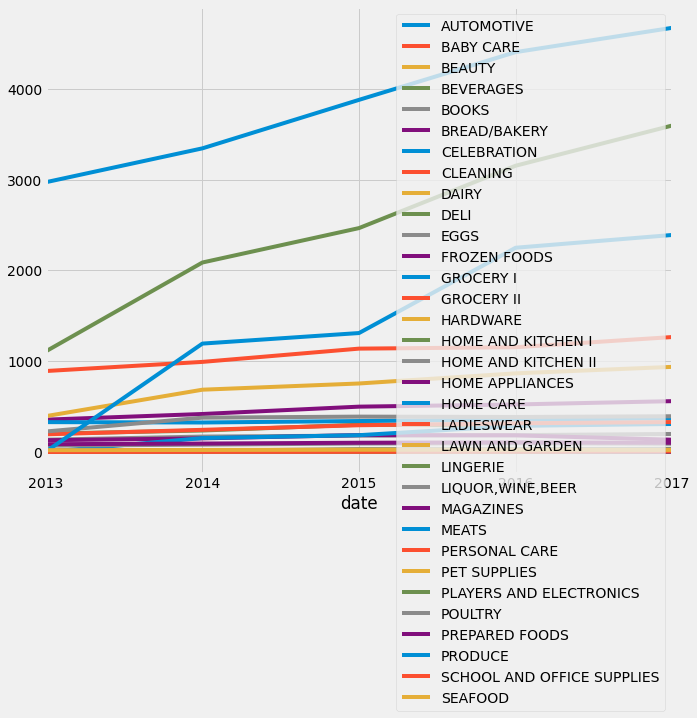

In [20]:
for f in train['family'].unique():
    p_df = train.loc[train['family']==f].set_index('date')
    
    p_df.resample('y').mean()['sales'].plot(label = f)
plt.legend()
plt.show()

<AxesSubplot:ylabel='family'>

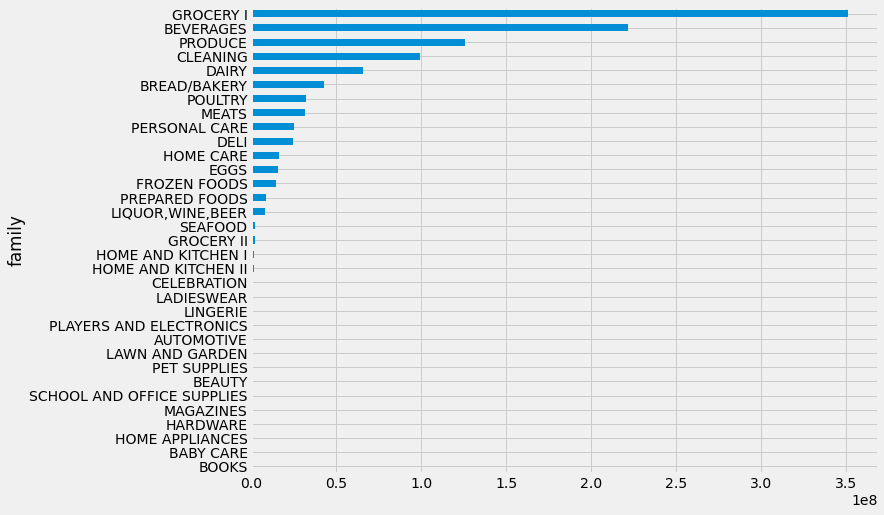

In [23]:
train.groupby('family')['sales'].sum().sort_values().plot.barh()

In [33]:
train['day']= train['date'].dt.day
train['dayofweek']= train['date'].dt.dayofweek
train['month']= train['date'].dt.month
train['year']= train['date'].dt.year

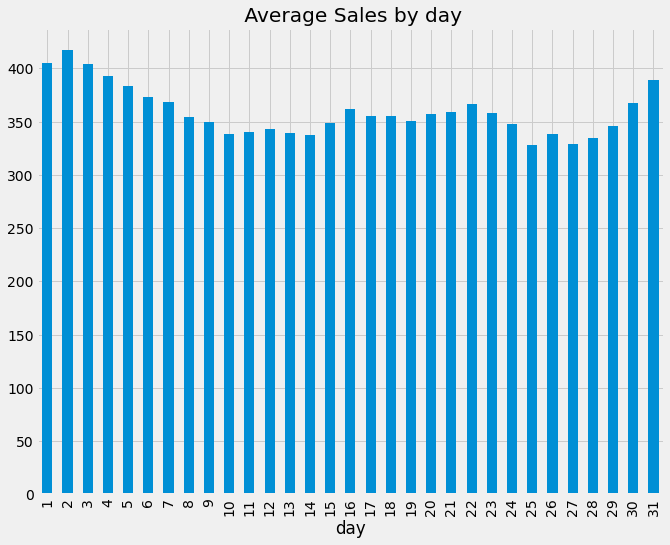

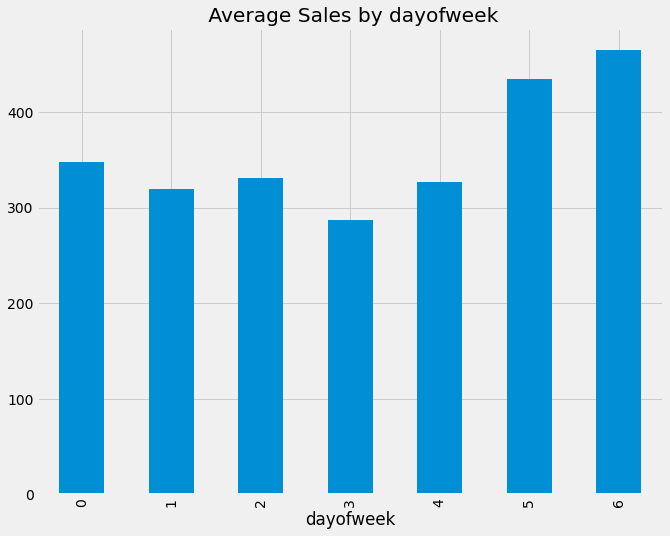

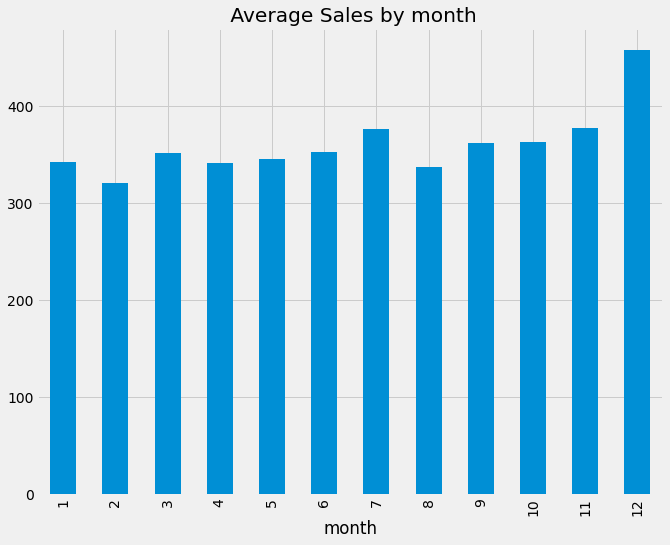

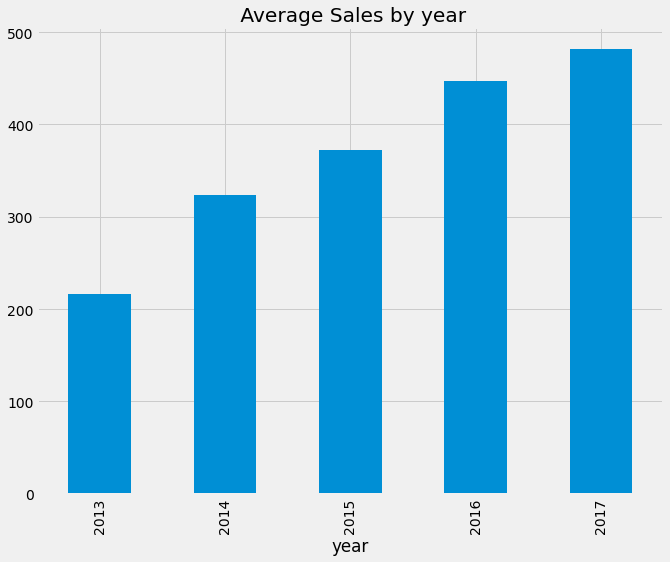

In [36]:
for p in ['day', 'dayofweek', 'month', 'year']:
    train.groupby(p)['sales'].mean().plot.bar(title = f' Average Sales by {p}')
    plt.show()

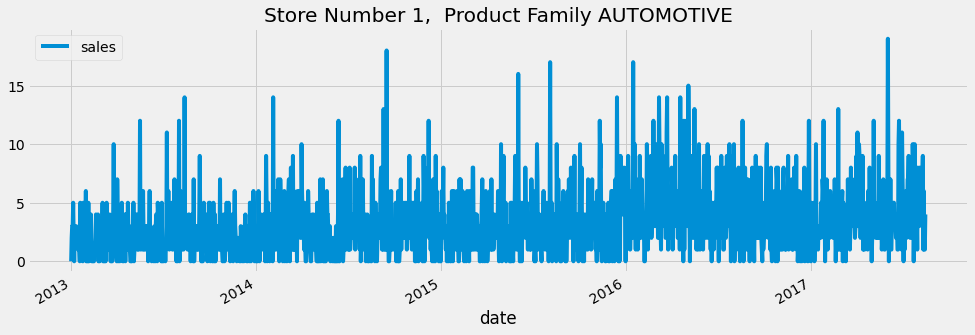

interactive(children=(Dropdown(description='store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

In [6]:
unique_stores = stores['store_nbr'].unique().tolist()
unique_famliy = train['family'].unique().tolist()
stores_widget = Dropdown(options = unique_stores)
category_widget = Dropdown(options = unique_famliy)

# Define a function that updates the content of y based on what we select for x
# def update(*args):
#     category_widget.options = train.loc[train['store_nbr']==stores_widget.value, 'family'].unique().tolist()
# stores_widget.observe(update)

# Some function you want executed
def plot_data(store, family):
    sales = train.loc[(train['store_nbr']==store) & (train['family']==family), ['date', 'sales']] 
    sales.set_index('date').plot(title = 'Store Number {},  Product Family {}'.format(store, family), figsize=(15,5))
    
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=sales['date'], y=sales['sales'],
#                         mode='lines',
#                         name='{},{}'.format(store, family)))
#     fig.update_layout(title_x = 0.5, title = 'Store Number {},  Product Family {}'.format(store, family))
#     fig.show()

interact(plot_data,
         store = stores_widget,
         family = category_widget);

In [7]:
# stores analysis

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

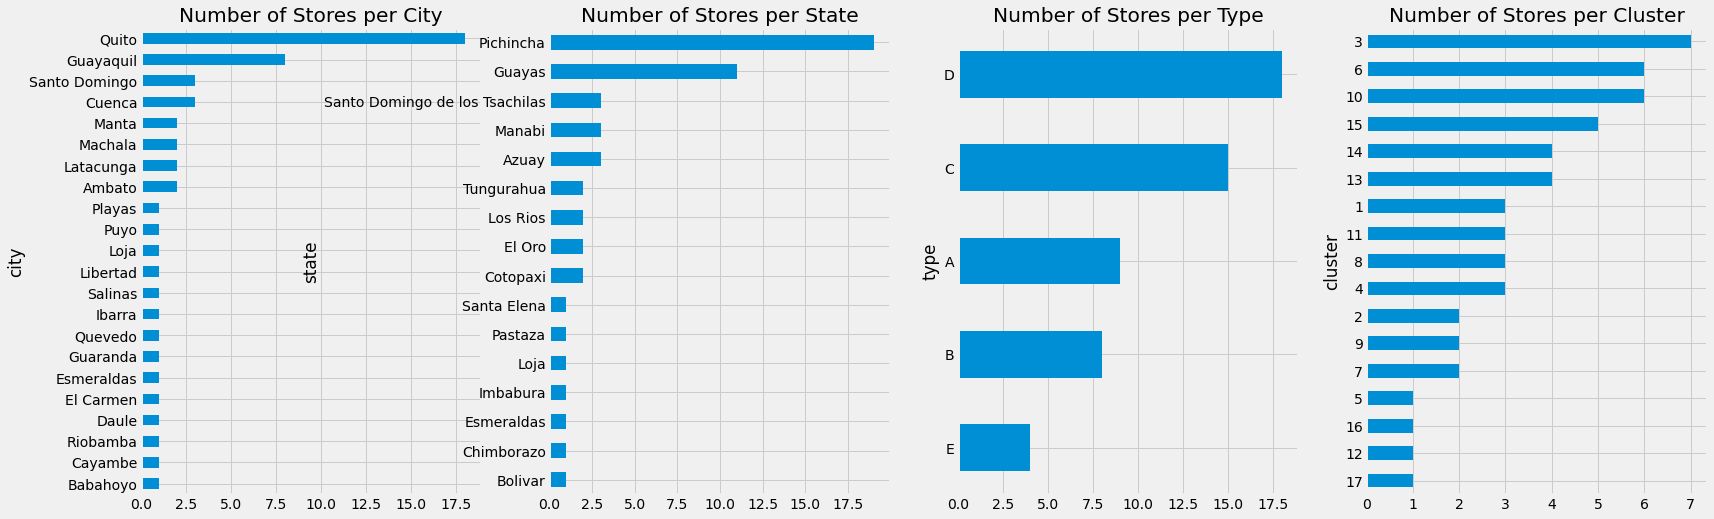

In [9]:
fig, ax = plt.subplots(1,4, figsize = (25,8))
for i, col in enumerate(['city', 'state', 'type', 'cluster']):
    stores.groupby(col)['store_nbr'].count().sort_values().plot.barh(title = 'Number of Stores per {}'.format(col.capitalize()), ax=  ax[i])


In [41]:
train.set_index('date').resample('d').mean()[['sales','dcoilwtico']].corr()


,sales,dcoilwtico
sales,1.000000,-0.705002
dcoilwtico,-0.705002,1.000000


# negative correlation, with Increase in oil price sales decreases

<AxesSubplot:title={'center':'Oil Prices VS Sales  (Scaled Values)'}, xlabel='date'>

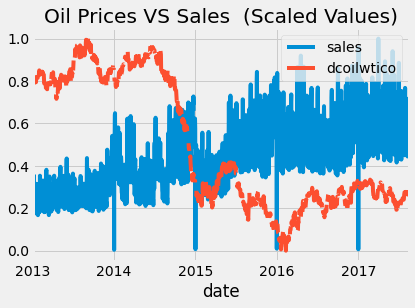

In [10]:
# plotting mean sales and oil prices with normalization
def scale_down(X):
    X_min = X.min()
    X_max = X.max()
    return (X - X_min)/(X_max - X_min)
train[['date','sales','dcoilwtico']].set_index('date')\
                                    .resample('d')\
                                    .mean()\
                                    .apply(scale_down, axis=0)\
                                    .plot(title = 'Oil Prices VS Sales  (Scaled Values)')

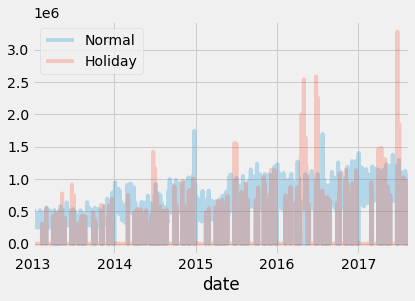

In [11]:
holidays_sales = train.loc[train['type'].isin(['Holiday','Event'])].set_index('date')
normal_sales = train.loc[~train['type'].isin(['Holiday','Event'])].set_index('date')

def plot_daily_sales(df, label):
    return df.resample('d').sum()['sales'].plot(alpha=0.25, label=label)


plot_daily_sales(normal_sales, label = 'Normal')
plot_daily_sales(holidays_sales, label='Holiday')
plt.legend()